In [ ]:
  from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import Library**

In [ ]:
pip install tensorflow==2.15.0 tensorflow-hub keras==2.15.0

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
import tensorflow_hub as hub
import numpy as np

In [ ]:
import pandas as pd

# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

In [ ]:
print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Version:  2.15.0
Hub version:  0.16.1
Eager mode:  True
GPU is NOT AVAILABLE


In [ ]:
data_root='/content/drive/MyDrive/Wayang/'

**Tahap Pre-Processing**

In [ ]:
train_path = '/content/drive/MyDrive/Wayang/train'
val_path = '/content/drive/MyDrive/Wayang/val'
IMAGE_SHAPE = (224, 224)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
rescale = 1/255)

valid_generator = valid_datagen.flow_from_directory(
    directory=val_path,
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1/255,
    shear_range=0.2,
    rotation_range=30,
    fill_mode='nearest',
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)
train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    shuffle=True,
    target_size=IMAGE_SHAPE)

Found 42 images belonging to 6 classes.
Found 168 images belonging to 6 classes.


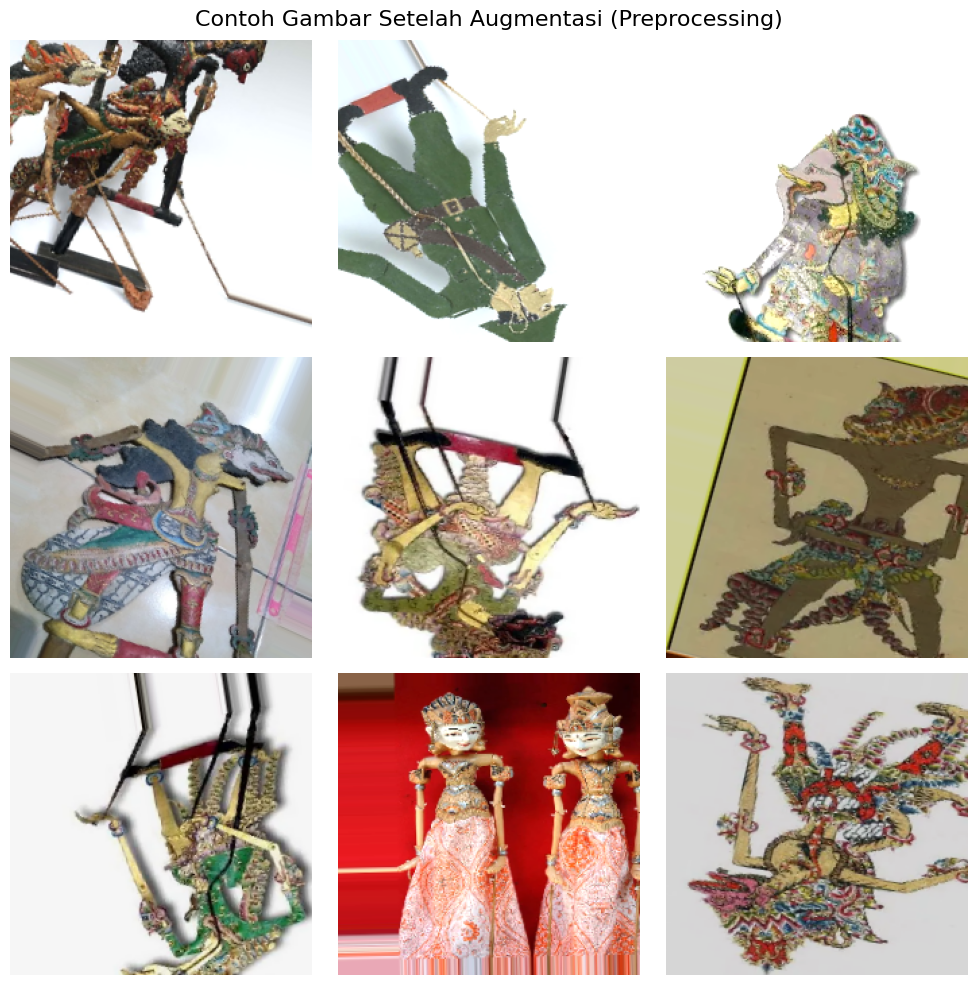

In [ ]:
# Ambil satu batch dari train_generator
images, labels = next(train_generator)

# Tampilkan 9 gambar pertama
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])  # Karena sudah di-rescale, tidak perlu denormalisasi
    plt.axis('off')
plt.suptitle("Contoh Gambar Setelah Augmentasi (Preprocessing)", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 6)
['Wayang Beber' 'Wayang Gedog' 'Wayang Golek' 'Wayang Krucil'
 'Wayang Kulit' 'Wayang Suluh']


**Model Training**

**Pembangunan Model CNN**

In [ ]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 2340358 (8.93 MB)
Trainable params: 82374 (321.77 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


**Tahap Compile Data**

In [ ]:
model.compile(
  optimizer=RMSprop(learning_rate=0.0001),
  loss='categorical_crossentropy',
  metrics=['acc'])

**Tahap Pelatihan Data**

In [ ]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(
    train_generator,
    epochs=40,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch)

Epoch 1/40
6/6 [==============================] - 118s 22s/step - loss: 2.0704 - acc: 0.2024 - val_loss: 1.7480 - val_acc: 0.2143
Epoch 2/40
6/6 [==============================] - 9s 1s/step - loss: 1.9113 - acc: 0.1726 - val_loss: 1.6571 - val_acc: 0.2381
Epoch 3/40
6/6 [==============================] - 8s 1s/step - loss: 1.7532 - acc: 0.2976 - val_loss: 1.5974 - val_acc: 0.2619
Epoch 4/40
6/6 [==============================] - 10s 1s/step - loss: 1.6424 - acc: 0.2738 - val_loss: 1.5370 - val_acc: 0.3571
Epoch 5/40
6/6 [==============================] - 10s 2s/step - loss: 1.5603 - acc: 0.3512 - val_loss: 1.4672 - val_acc: 0.3810
Epoch 6/40
6/6 [==============================] - 8s 1s/step - loss: 1.4956 - acc: 0.4048 - val_loss: 1.4176 - val_acc: 0.3810
Epoch 7/40
6/6 [==============================] - 11s 2s/step - loss: 1.4568 - acc: 0.4464 - val_loss: 1.3495 - val_acc: 0.5000
Epoch 8/40
6/6 [==============================] - 9s 2s/step - loss: 1.4517 - acc: 0.4583 - val_loss: 1.2

**Tahap Evaluasi Pelatihan Data**

In [ ]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

2/2 [==============================] - 1s 214ms/step - loss: 0.5742 - acc: 0.8333
Final loss: 0.57
Final accuracy: 83.33%


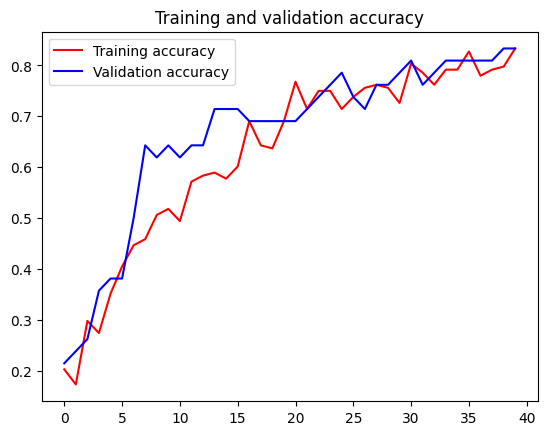

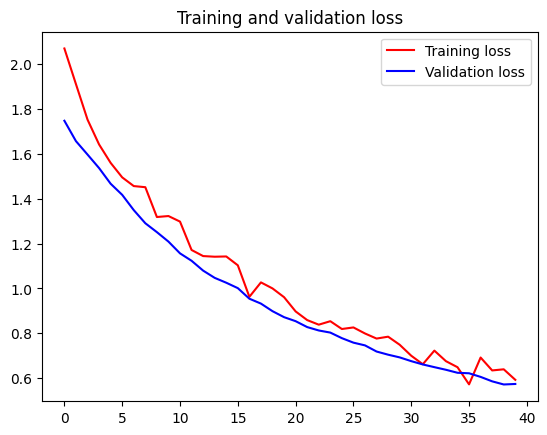

In [ ]:
#----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = hist.history['acc']
val_acc  = hist.history['val_acc']
loss     = hist.history['loss']
val_loss = hist.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot  ( epochs, val_acc, 'b', label='Validation accuracy')
plt.title ('Training and validation accuracy')
# plt.title('Training accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot  ( epochs, val_loss, 'b', label='Validation loss')
plt.title ('Training and validation loss')
# plt.title('Training loss')
plt.legend()

plt.show()

Found 42 images belonging to 6 classes.
2/2 [==============================] - 2s 208ms/step


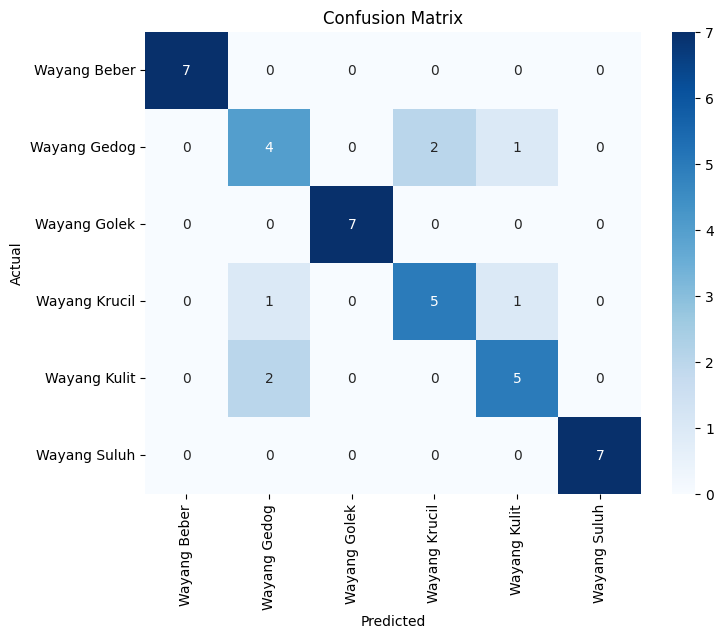

Classification Report:

               precision    recall  f1-score   support

 Wayang Beber       1.00      1.00      1.00         7
 Wayang Gedog       0.57      0.57      0.57         7
 Wayang Golek       1.00      1.00      1.00         7
Wayang Krucil       0.71      0.71      0.71         7
 Wayang Kulit       0.71      0.71      0.71         7
 Wayang Suluh       1.00      1.00      1.00         7

     accuracy                           0.83        42
    macro avg       0.83      0.83      0.83        42
 weighted avg       0.83      0.83      0.83        42



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Buat ulang generator validasi TANPA SHUFFLE
eval_generator = valid_datagen.flow_from_directory(
    directory=val_path,
    target_size=IMAGE_SHAPE,
    shuffle=False  # WAJIB! Agar urutan gambar dan label cocok
)

# Hitung jumlah langkah prediksi
eval_steps = np.ceil(eval_generator.samples / eval_generator.batch_size)

# Lakukan prediksi
predictions = model.predict(eval_generator, steps=eval_steps)

# Ambil prediksi kelas (argmax)
y_pred = np.argmax(predictions, axis=1)

# Ambil label asli
y_true = eval_generator.classes

# Ambil label nama kelas
class_names = list(eval_generator.class_indices.keys())

# 5. Buat confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 6. Tampilkan heatmap confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(cm, index=class_names, columns=class_names),
            annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 7. Tampilkan classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


**Saving Model**

In [ ]:
WAY_SAVED_MODEL = "saved_models/wayang"
tf.keras.models.save_model(model, WAY_SAVED_MODEL)

**Converting Model to TFlite**

In [ ]:
way_model = tf.keras.models.load_model(WAY_SAVED_MODEL,custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(WAY_SAVED_MODEL)
tflite_model = converter.convert()

open("Final_Train.tflite", "wb").write(tflite_model)

9194916

In [ ]:
from shutil import copyfile

In [ ]:
saved_model_path = "/content/Final_Train.tflite"
gdrive_saved_model_path = '/content/drive/MyDrive/Wayang/Wayang Model/FinalTrain'
copyfile(saved_model_path, gdrive_saved_model_path)

'/content/drive/MyDrive/Wayang/Wayang Model/FinalTrain'